In [1]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline
  
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# the following cells will use the rai framework for robot control, simulation and motion planning
# https://github.com/MarcToussaint/rai
import sys
import os 
print(os.getcwd())
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../../ry/')
sys.path.append('../../')
sys.path.append('../')
import libry as ry
import time
import gc
import os
from collections import defaultdict
import utils

# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
#os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
#os.environ["ROS_IP"] = "129.69.216.204"

/home/marc/git/uni/robotics-course/practical/clean


In [4]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
gc.collect()
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../rai-robotModels/baxter/baxter_new.g')
nodeName = ""#"studentMarcsNode"

q_home = C.getJointState()
q_zero = q_home * 0.
B = C.operate(nodeName)
B.sync(C)
C.makeObjectsConvex()
B.sendToReal(False)

In [5]:
def check_target(targetFrame):
    if not targetFrame in C.getFrameNames():
        frame = C.addObject(name=targetFrame, parent="base_footprint" ,shape=ry.ST.sphere, size=[.01], pos=[0,0,0], color=[0.,0.,1.])
    return C.frame(targetFrame)

def plan_path(targetPos, angle,targetFrame, gripperFrame, steps, time):
    target = check_target(targetFrame)
    rotM = utils.rotz(angle)
    B.sync(C)
    quat = utils.rotm2quat(rotM)
    target.setPosition(targetPos)
    target.setQuaternion(quat)
    pp = C.komo_path(1, 30, 10, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductYZ, frames=[gripperFrame, targetFrame], target=[0], time=[])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames= [gripperFrame, targetFrame], target= [1], time= [])
    pp.addObjective(type= ry.OT.sos,feature= ry.FS.qItself, frames= [], target= q_home, time= [1.])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.distance, frames= [gripperFrame, targetFrame], target= [-0.2], time= [.8])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= [gripperFrame, targetFrame], time= [1.])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself, frames= [], order= 1,  time= [0, 1])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        path += [q]
    return path, pp

In [6]:
B.moveHard(q_home)

In [ ]:
steps = 30; time = 5
p, _ = plan_path([0, 0.5, 1], 1.2, "ball", "baxterR", steps, time)

In [112]:
B.move(p, [time/steps * i for i in range(len(p))], False)

In [93]:
p

[array([ 0.     ,  0.08001, -0.08001, -1.00001, -1.00001,  1.17001,
        -1.17001,  1.94001,  1.94001, -0.67001,  0.67001,  1.02001,
         1.02001,  0.50001, -0.50001,  0.     ,  0.     ]),
 array([ 0.     ,  0.08001, -0.08001, -1.00001, -1.00001,  1.17001,
        -1.17001,  1.94001,  1.94001, -0.67001,  0.67001,  1.02001,
         1.02001,  0.50001, -0.50001,  0.     ,  0.     ]),
 array([ 0.     ,  0.08001, -0.08001, -1.00001, -1.00001,  1.17001,
        -1.17001,  1.94001,  1.94001, -0.67001,  0.67001,  1.02001,
         1.02001,  0.50001, -0.50001,  0.     ,  0.     ]),
 array([ 0.     ,  0.08001, -0.08001, -1.00001, -1.00001,  1.17001,
        -1.17001,  1.94001,  1.94001, -0.67001,  0.67001,  1.02001,
         1.02001,  0.50001, -0.50001,  0.     ,  0.     ]),
 array([ 0.     ,  0.08001, -0.08001, -1.00001, -1.00001,  1.17001,
        -1.17001,  1.94001,  1.94001, -0.67001,  0.67001,  1.02001,
         1.02001,  0.50001, -0.50001,  0.     ,  0.     ]),
 array([ 0.     ,  0

In [4]:
from webserver import sampleClient
import vision
import cv2
from skimage import measure, morphology

In [ ]:
cam = ry.Camera("camMarc", "/camera/color/image_raw", "/camera/depth/image_rect_raw", True)

In [57]:
img = cam.getRgb()
d = cam.getDepth()

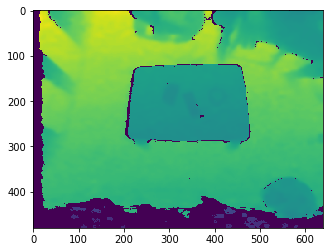

In [58]:
plt.imshow(d)

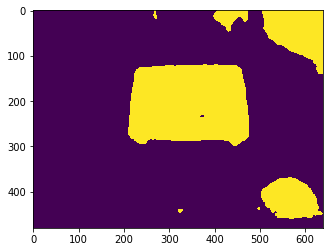

In [59]:
dm, m = vision.maskDepth(d, 1.,1.3 )
m = cv2.medianBlur(m.astype(np.uint8), 5)
plt.imshow(m)

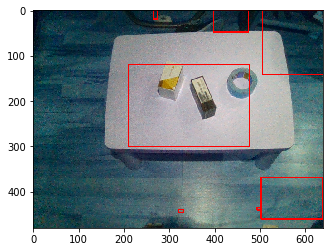

In [65]:
lbl = morphology.label(m, connectivity=2)
props = measure.regionprops(lbl)
img_1 = img.copy()
for prop in props:
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)
plt.imshow(img_1)

In [ ]:
grasp = sampleClient.predictGQCNN(img, d, host="http://localhost:5000")
vision.plotCircleAroundCenter(img, grasp["x"], grasp["y"])

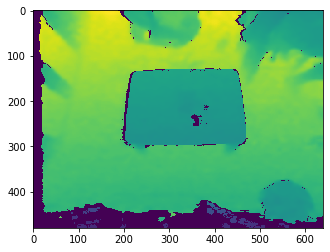

In [47]:
plt.imshow(d)